# How to defer node execution

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="/langgraphjs/concepts/low_level/#graphs">
                    Graphs
                </a>
            </li>
            <li>
                <a href="/langgraphjs/concepts/low_level/#nodes">
                    Nodes
                </a>
            </li>
            <li>
                <a href="/langgraphjs/concepts/low_level/#edges">
                    Edges
                </a>
            </li>
        </ul>
    </p>
</div>

Deferred node execution is useful when you want to delay the execution of a node until all other pending tasks are completed. This is particularly relevant when branches have different lenghts, which is common in workflows like map-reduce flows.

In [17]:
import { StateGraph, Annotation, START, END } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  aggregate: Annotation<string[]>({
    default: () => [],
    reducer: (acc, value) => [...acc, ...value],
  }),
});

const graph = new StateGraph(StateAnnotation)
  .addNode("a", (state) => {
    console.log(`Adding "A" to ${state.aggregate.join(", ")}`);
    return { aggregate: ["A"] };
  })
  .addNode("b", (state) => {
    console.log(`Adding "B" to ${state.aggregate.join(", ")}`);
    return { aggregate: ["B"] };
  })
  .addNode("b_2", (state) => {
    console.log(`Adding "B_2" to ${state.aggregate.join(", ")}`);
    return { aggregate: ["B_2"] };
  })
  .addNode("c", (state) => {
    console.log(`Adding "C" to ${state.aggregate.join(", ")}`);
    return { aggregate: ["C"] };
  })
  .addNode(
    "d",
    (state) => {
      console.log(`Adding "D" to ${state.aggregate.join(", ")}`);
      return { aggregate: ["D"] };
    },
    { defer: true }
  )
  .addEdge(START, "a")
  .addEdge("a", "b")
  .addEdge("a", "c")
  .addEdge("b", "b_2")
  .addEdge("b_2", "d")
  .addEdge("c", "d")
  .addEdge("d", END)
  .compile();


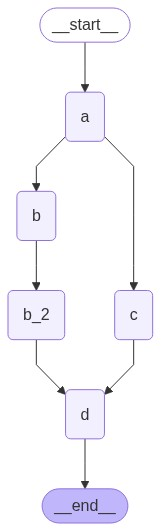

In [18]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

In [19]:
await graph.invoke({"aggregate": []})

Adding "A" to 
Adding "B" to A
Adding "C" to A
Adding "B_2" to A, B, C
Adding "D" to A, B, C, B_2
{ aggregate: [ 'A', 'B', 'C', 'B_2', 'D' ] }


In the above example, nodes `"b"` and `"c"` are executed concurrently in the same superstep. We set `{ defer: true }` on node `"d"` so it will not execute until all pending tasks are finished. In this case, this means that `"d"` waits until the entire branch `"b"` is finished.